In [5]:
using AlgebraicPetri

using LabelledArrays
using OrdinaryDiffEq
using Plots
using JSON

using Catlab
using Catlab.CategoricalAlgebra
using Catlab.Graphics
using Catlab.Programs
using Catlab.Theories
using Catlab.WiringDiagrams

display_uwd(ex) = to_graphviz(ex, box_labels=:name, junction_labels=:variable, edge_attrs=Dict(:len=>"1"));

In [6]:
ob(x::Symbol,n::Int) = codom(Open([x], LabelledReactionNet{Number,Int}(x=>n), [x])).ob;
function spontaneous_petri(transition::Symbol, rate::Number,
                           s::Symbol, s₀::Int,
                           t::Symbol, t₀::Int)
    Open(LabelledReactionNet{Number,Int}(unique((s=>s₀,t=>t₀)), (transition,rate)=>(s=>t)))
end;
function exposure_petri(transition::Symbol, rate::Number,
                        s::Symbol, s₀::Int,
                        i::Symbol, i₀::Int,
                        e::Symbol, e₀::Int)
    Open(LabelledReactionNet{Number,Int}(unique((s=>s₀,i=>i₀,e=>e₀)), (transition,rate)=>((s,i)=>(e,i))))
end;

### define parameters

In [7]:
N = 101;
beta = 0.1;
t_a = 2.9;
t_u = 2.72;
t_n = 6;
t_r = 3.5;

### define initial values

In [13]:
s0=100;
e0=0;
ia0=0;
iyu0=1;
iyn0=0;
ru0=0;

### Define an `oapply` function that connects the building block Petri nets to the operations we will use in the model.

In [9]:
F(ex) = oapply(ex, Dict(
        :exposure_a=>exposure_petri(Symbol(:exp_a), beta/N, Symbol(:S), s0, Symbol(:IA), ia0, Symbol(:E), e0),
        :exposure_yu=>exposure_petri(Symbol(:exp_yu), beta/N, Symbol(:S), s0, Symbol(:IYU), iyu0, Symbol(:E), e0),
        :exposure_yn=>exposure_petri(Symbol(:exp_yn), beta/N, Symbol(:S), s0, Symbol(:IYN), iyn0, Symbol(:E), e0),
        :asymptomatic_infection=>spontaneous_petri(Symbol(:new_infec), 1/t_a, Symbol(:E), e0, Symbol(:IA), ia0),
        :becoming_symptomatic=>spontaneous_petri(Symbol(:new_sympt), 1/t_u, Symbol(:IA), ia0, Symbol(:IYU), iyu0),
        :undiagnosed_sympt_NonComplications=>spontaneous_petri(Symbol(:undix_noncomp), 1/t_n, Symbol(:IYU), iyu0, Symbol(:IYN), iyn0),
        :undiagnosed_recovery=>spontaneous_petri(Symbol(:new_recover), 1/t_r, Symbol(:IYN), iyn0, Symbol(:RU), ru0)))

F (generic function with 1 method)

### define the `COVID-19` aggregate model structure of undirected wiring diagram using the `@relation` macro

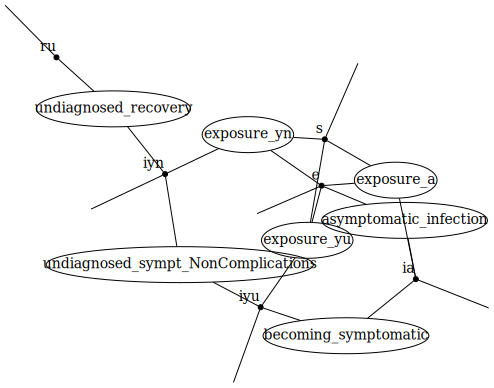

In [10]:
covid_aggrV1 = @relation (s, e, ia, iyu, iyn, ru) begin
    exposure_a(s, ia, e)
    exposure_yu(s, iyu, e)
    exposure_yn(s, iyn, e)
    asymptomatic_infection(e, ia)
    becoming_symptomatic(ia, iyu)
    undiagnosed_sympt_NonComplications(iyu, iyn)
    undiagnosed_recovery(iyn, ru)
end;
display_uwd(covid_aggrV1)

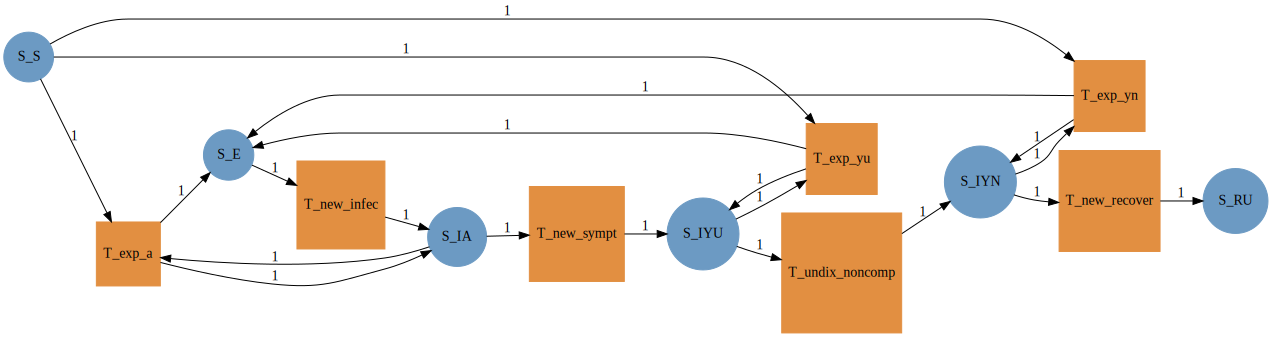

In [14]:
covidAggrV1_algpetri = apex(F(covid_aggrV1))
Graph(covidAggrV1_algpetri)

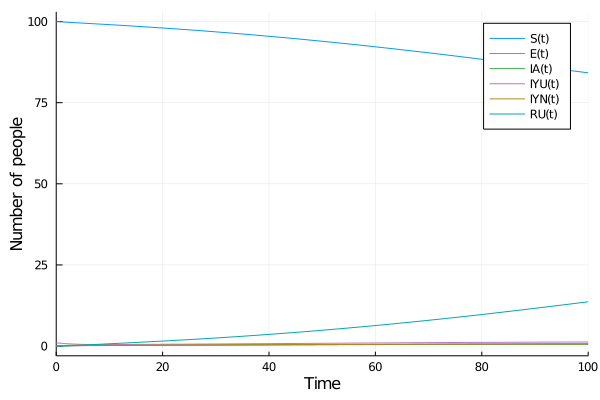

In [15]:
tspan = (0.0,100.0);
prob = ODEProblem(vectorfield(covidAggrV1_algpetri),concentrations(covidAggrV1_algpetri),tspan,rates(covidAggrV1_algpetri));
sol = solve(prob,Tsit5());
plot(sol, xlabel="Time", ylabel="Number of people")